In [3]:
# importing
import os
import glob
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 
import math
from cartopy.util import add_cyclic_point
from sklearn import linear_model as lm
import statsmodels.formula.api as stm

from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors
import matplotlib.gridspec as gridspec
import seaborn as sns
#import matplotlib.dates as mdates
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
#%config InlineBackend.figure_format = 'retina'

import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

mpl.rcParams['hatch.linewidth'] = 0.4
plt.rcParams['hatch.color'] = 'red'
plt.rcParams['hatch.color'] = 'red'
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.size'] = "16"
from matplotlib import rcParams
rcParams["mathtext.default"] = "regular"

import warnings
warnings.filterwarnings(action='ignore')

/dartfs-hpc/rc/home/q/f006fqq/.conda/envs/cl1020/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [4]:
root_dir = '/dartfs-hpc/rc/lab/C/CMIG'
data_dir = os.path.join(root_dir, 'nsiegert/projects/c4mip/data/resampled_prepped_data')
figure_dir = os.path.join(root_dir, 'clesk/projects/plcl/figs/precip/')
load_dir = os.path.join(root_dir, 'clesk/projects/plcl/data/hydro_deltas/')


model = 'CESM2'
experiment = '1pctCO2-bgc'
time = 'wateryear'

current_ensemble = ['BCC-CSM2-MR',
 'CESM2',
 'CMCC-ESM2',
 'CNRM-ESM2-1',
 'CanESM5',
 'CanESM5-CanOE',
 'EC-Earth3-CC',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'NorESM2-LM',
 'UKESM1-0-LL']

# list of experiments 
exp = ['1pctCO2', '1pctCO2-rad', '1pctCO2-bgc', 'nl', 'fullplant']

In [5]:
# load in the sftlf land masks for each model 
# and interpolate the mdl's lai mask from the ensemble mean.

# load ensemble mean lai mask (first30)
ensmean_laimask_first30 = xr.open_dataset(os.path.join(root_dir, 'nsiegert/projects/c4mip/data', 'ens_mean_lai_mask_f30.nc'))
lai_barren_mask = ensmean_laimask_first30.barrenmask

# list to store these mask da's
sftlf_landmask_list = {}
lai_mask_list = {}

# directory with the sftlf files
sftlf_dir = os.path.join(root_dir, 'nsiegert/projects/c4mip/data/download/sftlf')

# loop thru all models
for model in current_ensemble:
    
    # LAND MASK
    
    # open the model's land mask - just grab the first one 
    if model=='EC-Earth3-CC': 
        modelalt='EC-Earth3'   
        model_sftlf_wildcard = 'sftlf*' + modelalt + '*'
    else:
        model_sftlf_wildcard = 'sftlf*' + model + '*'
    
    # glob.glob returns a list I think.
    thismdl_landmasks = glob.glob(os.path.join(sftlf_dir, model_sftlf_wildcard))
    thismdl_landmask = xr.open_dataset(thismdl_landmasks[0])

    # check for this 'type' coord...
    if 'type' in thismdl_landmask.coords:
        # if it has one, drop it.
        thismdl_landmask = thismdl_landmask.drop('type')
    
    thismdl_landmask = thismdl_landmask.assign_coords({'model':model})
    
    # add that to land mask list
    sftlf_landmask_list[model] = (thismdl_landmask.sftlf / 100) # so it's in fraction of cell = land.
    
    # LAI MASK - interp() from ensemble mean lai mask
        
    # Interp LAI MASK
    thismdl_lai_mask = lai_barren_mask.interp_like(thismdl_landmask, method='nearest')
    #thismdl_lai_mask = thismdl_lai_mask.assign_coords({'model': model})
    # add INVERSE to the list (b/c 1 right now = barren. so want 1 to = keep, 0 = drop) 
    lai_mask_list[model] = (~(thismdl_lai_mask.astype('bool')))  
    #lai_mask_list = make_ensemble_concat_ds(lai_mask_list, timedim=False)

In [6]:
### cyclic pt barren mask
dat = lai_barren_mask
lat = lai_barren_mask.coords['lat']
lon = lai_barren_mask.coords['lon']
lon_idx = 1

wrap_data, wrap_lon = add_cyclic_point(dat, coord=lon, axis=lon_idx)

lai_barren_mask = xr.DataArray(data=wrap_data, 
                             dims=['lat','lon'],
                             coords=(lat.lat.data,wrap_lon))

#### plotting guts

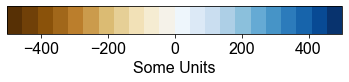

In [7]:
# load in brown/blue cmap from Justin

from numpy import genfromtxt

# read csv into array
j_cmap_arr = genfromtxt(os.path.join(root_dir, 'nsiegert/projects/c4mip/code/CMAP_RBGA.csv'), delimiter=',')
# drop empty columns
j_cmap_arr = np.delete(j_cmap_arr, [1,3,5], 1)

# read into an MPL Colormap (DISCRETE version)
jcmaptest = mpl.colors.LinearSegmentedColormap.from_list(name='JCMAP', colors=j_cmap_arr, N=22) # think about what N should actually be!

# visualize it I guess:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap_h = jcmaptest
norm_h = mpl.colors.Normalize(vmin=-500, vmax=500)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm_h, cmap=cmap_h),
             cax=ax, orientation='horizontal', label='Some Units')

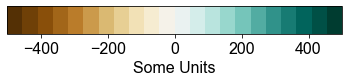

In [8]:
# make the Br_BG colormap

num_bins = 22
cmap_brG = cm.get_cmap('BrBG', num_bins)

# visualize it I guess
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = cmap_brG
norm = mpl.colors.Normalize(vmin=-500, vmax=500)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Some Units')

In [9]:
# load in greenland polygon and lakes feature

from cartopy.mpl.patch import geos_to_path
from shapely.geometry import Point
import cartopy.io.shapereader as shpreader
from cartopy import feature as cfeature

# open the shapefile
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')

reader = shpreader.Reader(shpfilename)
countries = reader.records()
country = next(countries)

# the polygon:
greenland_poly, = [country.geometry for country in countries
               if country.attributes['NAME'] == 'Greenland']

big_lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '110m',edgecolor='k', facecolor='white')

In [10]:
# load in the sftlf land masks for each model 
# and interpolate the mdl's lai mask from the ensemble mean.
cesm2_landmask = xr.open_dataset(os.path.join(root_dir, 'nsiegert/projects/c4mip/data/download/sftlf/sftlf_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc'))
cesm2_landmask = cesm2_landmask.sftlf >= 75

# load ensemble mean lai mask (first30)
ensmean_laimask_first30 = xr.open_dataset(os.path.join(root_dir, 'nsiegert/projects/c4mip/data', 'ens_mean_lai_mask_f30.nc'))
lai_barren_mask = ensmean_laimask_first30.barrenmask

# list to store these mask da's
sftlf_landmask_list = {}
lai_mask_list = {}

# directory with the sftlf files
sftlf_dir = os.path.join(root_dir, 'nsiegert/projects/c4mip/data/download/sftlf')

# loop thru all models
for model in current_ensemble:
    
    # LAND MASK
    
    # open the model's land mask - just grab the first one 
    if model=='EC-Earth3-CC': 
        modelalt='EC-Earth3'   
        model_sftlf_wildcard = 'sftlf*' + modelalt + '*'
    else:
        model_sftlf_wildcard = 'sftlf*' + model + '*'
    
    # glob.glob returns a list I think.
    thismdl_landmasks = glob.glob(os.path.join(sftlf_dir, model_sftlf_wildcard))
    thismdl_landmask = xr.open_dataset(thismdl_landmasks[0])

    # check for this 'type' coord...
    if 'type' in thismdl_landmask.coords:
        # if it has one, drop it.
        thismdl_landmask = thismdl_landmask.drop('type')
    
    thismdl_landmask = thismdl_landmask.assign_coords({'model':model})
    
    # add that to land mask list
    sftlf_landmask_list[model] = (thismdl_landmask.sftlf / 100) # so it's in fraction of cell = land.
    
    # LAI MASK - interp() from ensemble mean lai mask
        
    # Interp LAI MASK
    thismdl_lai_mask = lai_barren_mask.interp_like(thismdl_landmask, method='nearest')
    #thismdl_lai_mask = thismdl_lai_mask.assign_coords({'model': model})
    # add INVERSE to the list (b/c 1 right now = barren. so want 1 to = keep, 0 = drop) 
    lai_mask_list[model] = (~(thismdl_lai_mask.astype('bool')))  
    #lai_mask_list = make_ensemble_concat_ds(lai_mask_list, timedim=False)

In [11]:
### cyclic pt barren mask
dat = lai_barren_mask
lat = lai_barren_mask.coords['lat']
lon = lai_barren_mask.coords['lon']
lon_idx = 1

wrap_data, wrap_lon = add_cyclic_point(dat, coord=lon, axis=lon_idx)

lai_barren_mask = xr.DataArray(data=wrap_data, 
                             dims=['lat','lon'],
                             coords=(lat.lat.data,wrap_lon))

### cyclic pt land mask
dat = cesm2_landmask

lat = cesm2_landmask.coords['lat']
lon = cesm2_landmask.coords['lon']
lon_idx = 1

wrap_data, wrap_lon = add_cyclic_point(dat, coord=lon, axis=lon_idx)

landmask = xr.DataArray(data=wrap_data, 
                             dims=['lat','lon'],
                             coords=(lat.lat.data,wrap_lon))


[Text(1, 0.5, 'Agree: drying'),
 Text(1, 1.5, 'Agree: low change'),
 Text(1, 2.5, 'Agree: wetting'),
 Text(1, 3.5, 'Models disagree'),
 Text(1, 4.5, '')]

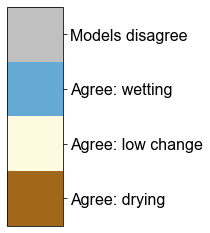

In [12]:
# CMAP FOR FRACTIONAL AGREEMENT


# create the new map
cmap_ag = mpl.colors.ListedColormap([cmap_h(3), '#fefae0', cmap_h(16),'silver'])


# define the bins and normalize
bounds = np.linspace(0, 4,5)
norm_ag = mpl.colors.BoundaryNorm(bounds, cmap_ag.N)

fig, ax = plt.subplots(figsize=(1, 8))
fig.subplots_adjust(bottom=0.5)

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_ag, cmap=cmap_ag),
             cax=ax, orientation='vertical',
             ticks=np.arange(0.5, cmap_ag.N+1,1))

cbar.ax.set_yticklabels(['Agree: drying', 'Agree: low change','Agree: wetting','Models disagree', ''])

In [13]:
def ensemble_agreement(data, tol=2, thresh_agree=0.67):
    """
    This function takes in ensemble var deltas and classifies ensemble agreement on sign of change.  
    Currently, within model change definition is defined as <-0.5SD or >0.5SD, parameter 'tol'. No change is between -0.5 and 0.5 SD.
    Agreement is defined as at least two thirds of models showing that change (+, -, no change)
    The classification codes:
    -agree negative as 0 (if fraction models agree neg > thresh_agree)
    -1 if agree no change
    -2 if agree +
    -3 if disagree (less than two-thirds agreement on either +, -, or no change)
    
    Params:
    ------
        var_std_deltas_list (list of xr datasets with standardized deltas (can be non-standardized too)
        
        tol (tolerance about zero for +, -, or no change, in SD)
        
        thresh_agree (fraction of models that must agree on +, -, or no change, else classify as disagree)
        
    Returns:
    -------
        xarray DS's of agreement for each experiment above        
    """    
    varname = list(dict(data.data_vars).keys())[0]
    agreement_ds_list = []
    
    # loop over expriments
    for e in exp:


        # compute fractional agreement (N models >/< tol)
        smdelpos = data.sel(experiment=e)[varname]>=tol
        frac_agree_pos = smdelpos.sum(dim='model')/len(current_ensemble)

        smdelneg = data.sel(experiment=e)[varname]<=-tol
        frac_agree_neg = smdelneg.sum(dim='model')/len(current_ensemble)

        smdelnoc = (data.sel(experiment=e)[varname]>=-tol) & (data.sel(experiment=e)[varname]<=tol)
        frac_agree_noc = smdelnoc.sum(dim='model')/len(current_ensemble)

        # classify agreement

        #agree_map = #0 if fraction models agree neg > thresh_agree, 1 if agree noc, 2 if agree +, 3 if disagree
        agreement=np.nan*np.zeros([data.dims['lat'],data.dims['lon']])
        agreement[frac_agree_neg>=thresh_agree] = 0
        agreement[frac_agree_noc>=thresh_agree] = 1
        agreement[frac_agree_pos>=thresh_agree] = 2
        agreement[(frac_agree_noc<thresh_agree) & (frac_agree_pos<thresh_agree) & (frac_agree_neg<thresh_agree)] = 3

        # put agreement in a new ds
        dvs = {'agreement':(['lat','lon'],agreement)}
        crds = {'lon':(['lon'],data.lon.data),'lat':(['lat'],data.lat.data),'experiment':e}

        ds_agreement = xr.Dataset(data_vars=dvs,coords=crds)

        #save agreement for this expriment
        agreement_ds_list.append(ds_agreement)

    # concat all those ds's along the 'model' dim, 
    all_agreement_ds = xr.concat(agreement_ds_list, dim='experiment')
    
    return all_agreement_ds

#### load data

In [12]:
### load deltas
deltaT = xr.open_dataset(os.path.join(root_dir,load_dir, 'deltaT_abs.nc'))
deltaLE = xr.open_dataset(os.path.join(root_dir,load_dir, 'deltaLE_abs.nc'))
deltaSE = xr.open_dataset(os.path.join(root_dir,load_dir, 'deltaSE_abs.nc'))
deltaQ = xr.open_dataset(os.path.join(root_dir,load_dir, 'deltaQ_abs.nc'))
deltaSM = xr.open_dataset(os.path.join(root_dir,load_dir, 'deltaSM_abs.nc'))
deltaP = xr.open_dataset(os.path.join(root_dir, 'clesk/projects/plcl/data/hydro_deltas/','deltaPr_abs.nc'))

deltaT_p = xr.open_dataset(os.path.join(root_dir,load_dir, 'deltaT_normP.nc'))
deltaQ_p = xr.open_dataset(os.path.join(root_dir,load_dir, 'deltaQ_normP.nc'))

deltaLAI = xr.open_dataset(os.path.join(root_dir,load_dir, 'deltaLAI_abs.nc'))

### load and prep raw time series output for ensemble:

t_list = {}
pr_list = {}
sm_list = {}
q_list = {}

for i,model in enumerate(current_ensemble):
    
    t_list[model] = {}
    pr_list[model] = {}
    sm_list[model] = {}
    q_list[model] = {}
    
    # load data
    lai_mask = lai_mask_list[model]
    
    for experiment in ['1pctCO2']:
        
        t = xr.open_dataset('{}/{}.{}.{}.{}.nc'.format(data_dir, 'tran', model, experiment, time))
        pr = xr.open_dataset('{}/{}.{}.{}.{}.nc'.format(data_dir, 'pr', model, experiment, time))
        sm = xr.open_dataset('{}/{}.{}.{}.{}.nc'.format(data_dir, 'mrso', model, experiment, time))
        q = xr.open_dataset('{}/{}.{}.{}.{}.nc'.format(data_dir, 'mrro', model, experiment, time))
        
        t.coords['mask'] = (('lat','lon'), lai_mask.data)
        pr.coords['mask'] = (('lat','lon'), lai_mask.data)
        sm.coords['mask'] = (('lat','lon'), lai_mask.data)
        q.coords['mask'] = (('lat','lon'), lai_mask.data)

        # model specific dimension fixes:
        if model == 'BCC-CSM2-MR':
            pr = pr.drop_sel(water_year=2001)

        t_list[model] = t
        pr_list[model] = pr
        sm_list[model] = sm
        q_list[model] = q
        

In [13]:
def cycregrid(da):

    varname = list(dict(da.data_vars).keys())[0]
    datrep = da.sel(lon=da.lon[-4])[varname].values
    dat = da[varname]
    dat[:,-1] = datrep+0.000001
    dat[:,-2] = datrep+0.000002
    dat[:,-3] = datrep+0.000002

    cycdat = xr.DataArray(data=dat,
                              dims=['lat','lon'],
                              coords=(da.lat.data,da.lon.data))

#     cycdat = cyclic_da.interp_like(cesm2_landmask,method='nearest')

#     datrep = cycdat.sel(lon=cycdat.lon[-2]).values
#     dat = cycdat
#     dat[:,-1] = datrep+0.001
#     dat[:,-2] = datrep+0.002


#     lat = cycdat.coords['lat']
#     lon = cycdat.coords['lon']
#     lon_idx = 1

#     wrap_data, wrap_lon = add_cyclic_point(dat, coord=lon, axis=lon_idx)
    
# #     if model in ['GFDL-ESM4','UKESM1-0-LL']:
# #         wrap_data[:,-1] = wrap_data[:,-2]
    
#     y = xr.DataArray(data=wrap_data, 
#                              dims=['lat','lon'],
#                              coords=(lat.lat.data,wrap_lon))

    return cycdat

In [14]:
baseT = []
baseP = []
baseQ = []
sdT = []
sdP = []
sdQ = []

for i,model in enumerate(current_ensemble):

    baseT.append(t_list[model].where(t_list[model].mask).sel(water_year=t_list[model].water_year[2:32]).mean(dim='water_year').interp_like(deltaT.sel(experiment='1pctCO2-bgc',model=model).deltaT,method='nearest').tran)
    baseP.append(pr_list[model].where(pr_list[model].mask).sel(water_year=pr_list[model].water_year[2:32]).mean(dim='water_year').interp_like(deltaP.sel(experiment='1pctCO2-bgc',model=model).deltaPr,method='nearest').pr)
    baseQ.append(q_list[model].where(q_list[model].mask).sel(water_year=q_list[model].water_year[2:32]).mean(dim='water_year').interp_like(deltaQ.sel(experiment='1pctCO2-bgc',model=model).deltaQ,method='nearest').mrro)
    
    sdrgrdT = t_list[model].where(t_list[model].mask).sel(water_year=t_list[model].water_year[2:32]).std(dim='water_year').interp_like(deltaT.sel(experiment='1pctCO2-bgc',model=model).deltaT,method='nearest')
    sdT.append(cycregrid(sdrgrdT))
    sdrgrdP = pr_list[model].where(pr_list[model].mask).sel(water_year=pr_list[model].water_year[2:32]).std(dim='water_year').interp_like(deltaP.sel(experiment='1pctCO2-bgc',model=model).deltaPr,method='nearest')
    sdP.append(cycregrid(sdrgrdP))
    sdrgrdQ = q_list[model].where(q_list[model].mask).sel(water_year=q_list[model].water_year[2:32]).std(dim='water_year').interp_like(deltaQ.sel(experiment='1pctCO2-bgc',model=model).deltaQ,method='nearest')
    sdQ.append(cycregrid(sdrgrdQ))

baseT = xr.concat(baseT,dim='model')
baseP = xr.concat(baseP,dim='model')
baseQ = xr.concat(baseQ,dim='model')

sdT = xr.concat(sdT,dim='model')
sdP = xr.concat(sdP,dim='model')
sdQ = xr.concat(sdQ,dim='model')

In [15]:
# convert absolute deltas to sd deltas, for sigma/4 tolerance criterion
deltaT_p = deltaT/sdT
deltaP_p = deltaP/sdP
deltaQ_p = deltaQ/sdQ 



In [16]:
#set sigma/4 tolerance criterion
tol = 0.25
#set 2/3 model agreement on sign criterion
thresh_agree = 2/3

#calculate agreement classification
deltaT_p_agr = ensemble_agreement(deltaT_p,tol=tol,thresh_agree=thresh_agree)
deltaP_p_agr = ensemble_agreement(deltaP_p,tol=tol,thresh_agree=thresh_agree)
deltaQ_p_agr = ensemble_agreement(deltaQ_p,tol=tol,thresh_agree=thresh_agree)


In [17]:
# function to get fractional land area within each agreement class
def agreeAreaFrac(data):
    agrland = data.agreement.where(landmask)
    agrland = agrland.where(1-lai_barren_mask)
    
    agr_area_neg = (agrland==0).weighted(np.cos(np.deg2rad(agrland.lat))).sum(dim=['lat','lon'])
    agr_area_pos = (agrland==2).weighted(np.cos(np.deg2rad(agrland.lat))).sum(dim=['lat','lon'])
    agr_area_total = (agrland<3).weighted(np.cos(np.deg2rad(agrland.lat))).sum(dim=['lat','lon'])
    total_area = landmask.where(1-lai_barren_mask).weighted(np.cos(np.deg2rad(landmask.lat))).sum(dim=['lat','lon'])
    
    fracs = np.array([agr_area_neg/total_area,agr_area_pos/total_area,agr_area_total/total_area])
    return fracs.round(2)


### plot ensemble agreement on hydrologic changes 

0
3
6


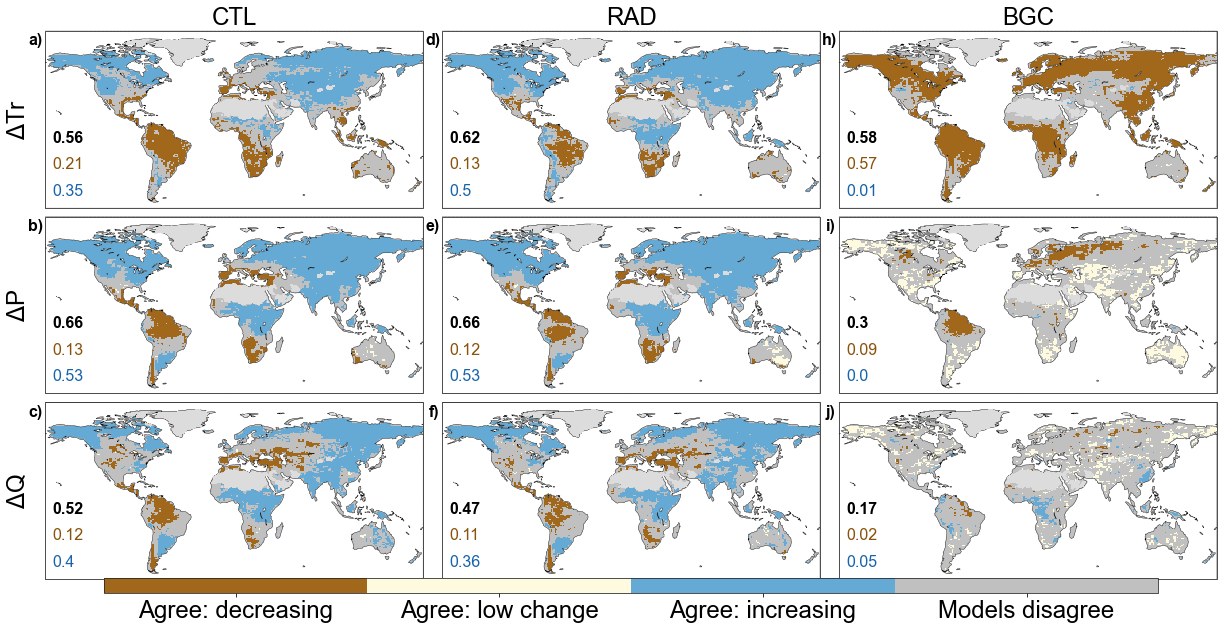

In [82]:
# inputs:
var = [deltaT_p_agr, deltaP_p_agr, deltaQ_p_agr]
vartitle = [r'$\Delta Tr$',r'$\Delta P$',r'$\Delta Q$']
varname = ['deltaT','deltaP','deltaQ']


# plot title
plttitle = ''#'Ensemble spread and agreement'

# number of vars
nrows = 3
ncols = 3
exp = ['1pctCO2', '1pctCO2-rad', '1pctCO2-bgc']#,'fullplant']
exptitle = ['CTL','RAD','BGC']#,'Full Plant']

let = ['a)','b)','c)','d)','e)','f)','h)','i)','j)']
## FIGURE SETUP

# font stuff
#sns.set(font_scale=1.7, style="dark")
fsize=24
# make a figure
fig = plt.figure(figsize=(ncols*7,nrows*4.5)) # EDIT HERE
# set up grid for subplots & spacing
gs = gridspec.GridSpec(nrows=nrows+1, ncols=ncols, figure=fig) # I edited here. just say 4row 4col
gs.update(wspace=0.05, hspace=0.05)
# plot edge colors
plt.rcParams["axes.edgecolor"] = "0.15"
# list to hold our subplot axes
axes = []

# plot counter var
pltcntr = 0

# # loop thru cols, rows - b/c of the order I loaded in the data. 
for col in range(ncols):
    print(pltcntr)
    for row in range(nrows):
        
        # add an axis:
        ax = fig.add_subplot(gs[row,col], projection=ccrs.PlateCarree())
        
        # select ensemble mean data for desired var
        # data = input_dslist[col][0].sel(experiment=exp[row])
        # datavar = full_var_list[col]

        # select appropriate cmap and norm depending on which var.
        cmap = cmap_ag
        norm = norm_ag
        bounds = [0,4]
           
        # open ∆ctr data for this var
        var_toplot = var[row]
       
        # select significance mask, pass to cyclic point fn so it plots nicely... (cyc point fn accepts a dataset as an arg...)
        # if col == 0:
        #     sig_toplot = add_cyclic_to_da(((data.KS_Pval<0.05)).to_dataset(name='sig')) 
        #     ax.contourf(sig_toplot.lon, sig_toplot.lat, (~sig_toplot.sig), levels=[0.5, 1], colors='white', transform=ccrs.PlateCarree())

        # plot the data onto the ax
        var_toplot.sel(experiment=exp[col]).agreement.plot(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
        
        # add BARREN MASK FROM LAI
        # add ensemble mean lai mask
        ax.contourf(lai_barren_mask.lon, lai_barren_mask.lat, lai_barren_mask.data, levels=[0.5, 1], colors='gainsboro', transform=ccrs.PlateCarree(), zorder=3)
        
    
        # ADDITIONAL AXIS EDITS:

        # 'turn off' default plot title
        ax.set(title='')

        # add column (in this case, experiment) name above if we're on the first ROW 
        if row==0:
            ax.set_title(exptitle[col],fontsize=fsize)

        # add var name name on the left if we're in the first COLUMN
        if col==0:
            ax.text(x=-0.07, y=0.50, s=vartitle[row], va='center', ha='center',
                rotation='vertical', rotation_mode='anchor',
                transform=ax.transAxes,fontsize=fsize)

        
        #agree area label:
        frac_agree_area = agreeAreaFrac(var_toplot.sel(experiment=exp[col]))
        ax.text(0.02,0.37,frac_agree_area[2],transform=ax.transAxes,weight='bold')
        ax.text(0.02,0.22,frac_agree_area[0],transform=ax.transAxes,color=cmap_h(2))
        ax.text(0.02,0.07,frac_agree_area[1],transform=ax.transAxes,color=cmap_h(19))
        

        if let[pltcntr] in ['i)','f)','j)']:
            x = -0.035
        else:
            x = -0.045
        ax.text(x,.92,let[pltcntr],transform=ax.transAxes,weight='bold')
        
        
                
        # spacing:
        plt.subplots_adjust(hspace=0.05)
        # Trim antarctica out of our axis extents
        ax.set_extent((-170,180,-60,90), crs=ccrs.PlateCarree())
        # ocean & coastline
        ax.add_feature(cartopy.feature.OCEAN,zorder=2,edgecolor='black',facecolor='white',linewidth=0.4) # ocean clr?
        # big lakes
        ax.add_feature(big_lakes, linewidth=0.4, zorder=3,linestyle='-', edgecolor='black', facecolor='white')
        # greenland
        ax.add_geometries([greenland_poly], crs=ccrs.PlateCarree(), facecolor='gainsboro')
        ax.set_aspect("auto") 
        axes.append(ax)
        
        # update plot counter
        pltcntr += 1
        
        # add agreement colorbar
        #if pltcntr == 3:


# overall plot title:        
plt.suptitle(plttitle, y=0.95) # note: will have to change y if i change axis sizes...
 

ax = fig.add_subplot(gs[nrows,0:ncols],anchor=(0.5,0))
ax.set_visible(False)

cbar_ag = plt.colorbar(mpl.cm.ScalarMappable(norm=norm_ag, cmap=cmap_ag),ax=ax,
     ticks=np.arange(0.5, cmap_ag.N+1,1),
     orientation='horizontal',
     location='bottom',
     shrink=0.9,
     aspect=70,
     anchor=(0.5,15))
    # panchor=(0,0))  # (left, down)

#cbar_ag.ax.set_yticks([0.5,1.5,2.5,3.5])
cbar_ag.ax.set_xticklabels(['Agree: decreasing', 'Agree: low change','Agree: increasing','Models disagree',''],fontsize=fsize)
        
# add time and script name to bottom of plot...
# get datetime
#now = datetime.now()

# add text
#fig.text(0.11, 0.05, 'Created: %s' %now.strftime("%Y-%m-%d %H:%M:%S"), fontsize='small')
#fig.text(0.9, 0.05, scriptname, ha='right', fontsize='small')


# SAVE FIGURE
# if savefig == True:
#     print('saving figure.', flush=True)
#     # SAVING AS png
#     plt.savefig(os.path.join(figure_dir, 'soil-moisture-ensemble-agreement.pdf'), format='pdf', facecolor='white', transparent=False)
    # AND as pdf
    #plt.savefig(os.path.join(figure_dir, 'greening_drying_plt_KS_test_wateryear_6_1.pdf'), format='pdf')
    
# SHOW:
plt.tight_layout(h_pad=15,w_pad=3)

#plt.savefig(figure_dir + 'Fig1.pdf',bbox_inches='tight')
#plt.savefig(figure_dir + 'Fig1.png',bbox_inches='tight')


fig 1 agreement as % of srex regions (notably, amazon)

In [18]:
def flip_lon_ll(da):
    # flip 360 to 180 lon
    # for lat-lon xarray dataarray
    # written by Chris Callahan

    # get coords
    lat_da = da.coords["lat"]
    lon_da = da.coords["lon"]

    # flip lon
    lon_180 = lon_da.values + 180

    srex_shift = np.full(da.shape,np.nan)
    srex_shift[:,96:] = da.data[:,:96]
    srex_shift[:,:96] = da.data[:,96:]
    
    # new data array
    da_180 = xr.DataArray(srex_shift,
                          coords=[lat_da,lon_180],
                          dims=["lat","lon"])

    # flip dataarray so it goes from -180 to 180
    # (instead of 0-180, -180-0)
    # lon_min_neg = np.amin(lon_180[lon_180<0])
    # lon_max_neg = np.amax(lon_180[lon_180<0])
    # lon_min_pos = np.amin(lon_180[lon_180>=0])
    # lon_max_pos = np.amax(lon_180[lon_180>=0])
    # da_180_flip = xr.concat([da_180.loc[:,lon_min_neg:lon_max_neg],
    #                          da_180.loc[:,lon_min_pos:lon_max_pos]],
    #                         dim="lon")
    return(da_180)

srex = xr.open_dataset(root_dir+'/clesk/projects/plcl/data/SREX_regions_mask_1.875x1.875.nc')
srex = flip_lon_ll(srex.region)
srex = srex.interp_like(deltaT_p_agr)

#deltaT_p_agr.sel(experiment='1pctCO2-bgc').agreement.plot()

In [19]:
qdown_amazon = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').where(srex==7).agreement == 0)
tdown_amazon = (deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==7).agreement == 0)
amazon = srex==7

In [20]:
### percent of amazon where q decline is robust
qdown_amazon.where(landmask).weighted(np.cos(np.deg2rad(srex.lat))).sum(dim=['lat','lon']) / amazon.where(landmask).weighted(np.cos(np.deg2rad(srex.lat))).sum(dim=['lat','lon']) 

<xarray.DataArray ()>
array(0.0805644)
Coordinates:
    experiment  <U11 '1pctCO2-bgc'

In [21]:
### percent of amazon where t and p decline is robust
tdfr = tdown_amazon.where(landmask).weighted(np.cos(np.deg2rad(srex.lat))).sum(dim=['lat','lon']) / amazon.where(landmask).weighted(np.cos(np.deg2rad(srex.lat))).sum(dim=['lat','lon']) 
pdown_amazon = (deltaP_p_agr.sel(experiment='1pctCO2-bgc').where(srex==7).agreement == 0)
pdfr = pdown_amazon.where(landmask).weighted(np.cos(np.deg2rad(srex.lat))).sum(dim=['lat','lon']) / amazon.where(landmask).weighted(np.cos(np.deg2rad(srex.lat))).sum(dim=['lat','lon'])  

print(tdfr)
print(pdfr)


<xarray.DataArray ()>
array(0.97162799)
Coordinates:
    experiment  <U11 '1pctCO2-bgc'
<xarray.DataArray ()>
array(0.57478268)
Coordinates:
    experiment  <U11 '1pctCO2-bgc'


In [22]:
### percent of amazon where T decline is robust
(deltaT_p_agr.where(landmask).sel(experiment='1pctCO2-bgc').where(srex==7).agreement == 0).weighted(np.cos(np.deg2rad(srex.lat))).sum(dim=['lat','lon'])  / amazon.where(landmask).weighted(np.cos(np.deg2rad(srex.lat))).sum(dim=['lat','lon']) 

<xarray.DataArray ()>
array(0.97162799)
Coordinates:
    experiment  <U11 '1pctCO2-bgc'

In [23]:
### percent of where T declines where Q also declines 
qdown_amazon.where(landmask).weighted(np.cos(np.deg2rad(srex.lat))).sum(dim=['lat','lon']) / (deltaT_p_agr.where(landmask).sel(experiment='1pctCO2-bgc').where(srex==7).agreement == 0).weighted(np.cos(np.deg2rad(srex.lat))).sum(dim=['lat','lon'])

<xarray.DataArray 'agreement' ()>
array(0.08291692)
Coordinates:
    experiment  <U11 '1pctCO2-bgc'

In [24]:
#west africa
waf = (srex == 15)
qup_af = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').where(srex==15).agreement == 2)
qup_af.where(landmask).weighted(np.cos(np.deg2rad(srex.lat))).sum(dim=['lat','lon'])  / waf.where(landmask).weighted(np.cos(np.deg2rad(srex.lat))).sum(dim=['lat','lon']) 

<xarray.DataArray ()>
array(0.3427457)
Coordinates:
    experiment  <U11 '1pctCO2-bgc'

In [25]:
#se asia
seas = (srex == 24)
qup_seas = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').where(srex==24).agreement == 2)
qup_seas.where(landmask).weighted(np.cos(np.deg2rad(srex.lat))).sum(dim=['lat','lon'])  / seas.where(landmask).weighted(np.cos(np.deg2rad(srex.lat))).sum(dim=['lat','lon']) 

<xarray.DataArray ()>
array(0.16877711)
Coordinates:
    experiment  <U11 '1pctCO2-bgc'

In [26]:
#andes
andes = (srex == 9)
qup_andes = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').where(srex==9).agreement == 2)
qup_andes.where(landmask).weighted(np.cos(np.deg2rad(srex.lat))).sum(dim=['lat','lon'])  / andes.where(landmask).weighted(np.cos(np.deg2rad(srex.lat))).sum(dim=['lat','lon']) 

<xarray.DataArray ()>
array(0.07370729)
Coordinates:
    experiment  <U11 '1pctCO2-bgc'

In [27]:
#e asia
eas = (srex == 22)
qup_eas = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').where(srex==22).agreement == 2)
qup_eas.where(landmask).weighted(np.cos(np.deg2rad(srex.lat))).sum(dim=['lat','lon'])  / eas.where(landmask).weighted(np.cos(np.deg2rad(srex.lat))).sum(dim=['lat','lon']) 


<xarray.DataArray ()>
array(0.15635441)
Coordinates:
    experiment  <U11 '1pctCO2-bgc'

In [19]:
def getArea(d):
    return d.where(landmask).weighted(np.cos(np.deg2rad(srex.lat))).sum(dim=['lat','lon'])
#def getAFracs(region):
region = 15
reg = srex == region
agrQT = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').where(srex==region).agreement == 2) & (deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==region).agreement == 0)
agrQnT = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').where(srex==region).agreement == 2) & ~(deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==region).agreement == 0)
agrT = (deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==region).agreement == 0)

fracQ = getArea(agrQ)/getArea(reg)
fracT = getArea(agrT)/getArea(reg)
fracQnT = getArea(agrQnT)/getArea(reg)


NameError: name 'agrQ' is not defined

Text(4.05, 1.08, 'Drying regions')

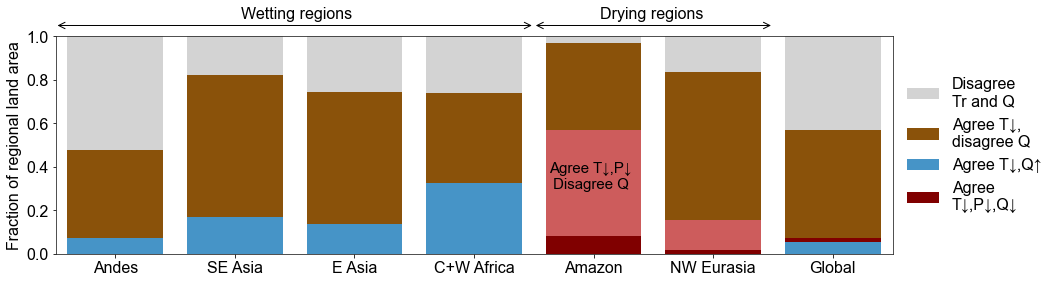

In [130]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(15,4))

axs = []
gs = GridSpec(1, 1)

axs.append(fig.add_subplot(gs[:,:]))

#runoff increasing areas
regns = [9,24,22,15]
regnameswet = ['Andes','SE Asia','E Asia','C+W Africa'] 
ax = axs[0]

for i,r in enumerate(regns):

    reg = srex == r
    agrQT = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 2) & (deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)
    agrQnT = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 2) & ~(deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)
    agrT = (deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)

    fracQT = getArea(agrQT)/getArea(reg)
    fracT = getArea(agrT)/getArea(reg)
    fracQnT = getArea(agrQnT)/getArea(reg)
    
    ax.bar(i,1,color='lightgrey')
    ax.bar(i,fracT,color=cmap_h(2))
    ax.bar(i,fracQT,color=cmap_h(17))
    

# runoff decreasing areas
offset = len(regnameswet)
regns = [7,18]# [12,13,18]
regnamesdry = ['Amazon','NW Eurasia'] 

for i,r in enumerate(regns):

    reg = srex == r
    agrQT = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0) & (deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)
    agrP = (deltaP_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)
    agrT = (deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)
    agrTP = (deltaP_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0) & agrT
    agrTPQ = agrQT & agrTP

    fracQT = getArea(agrQT)/getArea(reg)
    fracT = getArea(agrT)/getArea(reg)
    fracTP = getArea(agrTP)/getArea(reg)
    fracTPQ = getArea(agrTPQ)/getArea(reg)
    
    ax.bar(i+offset,1,color='lightgrey')
    ax.bar(i+offset,fracT,color=cmap_h(2))
    ax.bar(i+offset,fracTP,color='indianred')
    b4=ax.bar(i+offset,fracTPQ,color='maroon')
    
ax.text(offset-0.37,0.3,'Agree T↓,P↓\n Disagree Q',fontsize=15)

### global    
agrQT = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').agreement == 2) #& (deltaT_p_agr.sel(experiment='1pctCO2-bgc').agreement == 0)
agrQ = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').agreement == 0)
agrT = (deltaT_p_agr.sel(experiment='1pctCO2-bgc').agreement == 0)
fracQT = getArea(agrQT)/getArea(landmask.where(1-lai_barren_mask))
fracT = getArea(agrT)/getArea(landmask.where(1-lai_barren_mask))
fracQ = getArea(agrQ)/getArea(landmask.where(1-lai_barren_mask))

b1=ax.bar(i+offset+1,1,color='lightgrey')
b2=ax.bar(i+offset+1,fracT,color=cmap_h(2))
b3=ax.bar(i+offset+1,fracQT,color=cmap_h(17))
ax.bar(i+offset+1,fracQ,bottom=fracQT,color='maroon')
#ax.bar(i+1,fracQT,bottom=fracQnT,color='darkturquoise')   

xtlabs = regnameswet+regnamesdry+['Global']
ax.set_ylim(0,1)
ax.set_xticks(np.arange(0,len(xtlabs),1))
ax.set_xticklabels(xtlabs)
ax.set_ylabel('Fraction of regional land area')

ax.legend([b1,b2,b3,b4],['Disagree\nTr and Q','Agree T↓,\ndisagree Q','Agree T↓,Q↑','Agree\nT↓,P↓,Q↓'],loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)#,ncol=3)

## overlines
lny = 1.05
ax.set_xlim(-0.5,len(xtlabs)-0.5)
ax.annotate('', xy=(0, lny), xycoords='axes fraction', xytext=(4/7, lny),arrowprops=dict(arrowstyle="<->", color='k'))
ax.annotate('', xy=(4/7, lny), xycoords='axes fraction', xytext=(6/7, lny),arrowprops=dict(arrowstyle="<->", color='k'))
ax.text(1.05,1.08,'Wetting regions')
ax.text(4.05,1.08,'Drying regions')

In [80]:
[fracT,fracTP,fracQT,fracTPQ]

[<xarray.DataArray ()>
 array(0.83633174)
 Coordinates:
     experiment  <U11 '1pctCO2-bgc',
 <xarray.DataArray ()>
 array(0.15570529)
 Coordinates:
     experiment  <U11 '1pctCO2-bgc',
 <xarray.DataArray ()>
 array(0.02973477)
 Coordinates:
     experiment  <U11 '1pctCO2-bgc',
 <xarray.DataArray ()>
 array(0.01779151)
 Coordinates:
     experiment  <U11 '1pctCO2-bgc']

In [ ]:
plt.rcParams['hatch.linewidth'] = 1

### agreement with fractional global/regional barplots

0
3
6


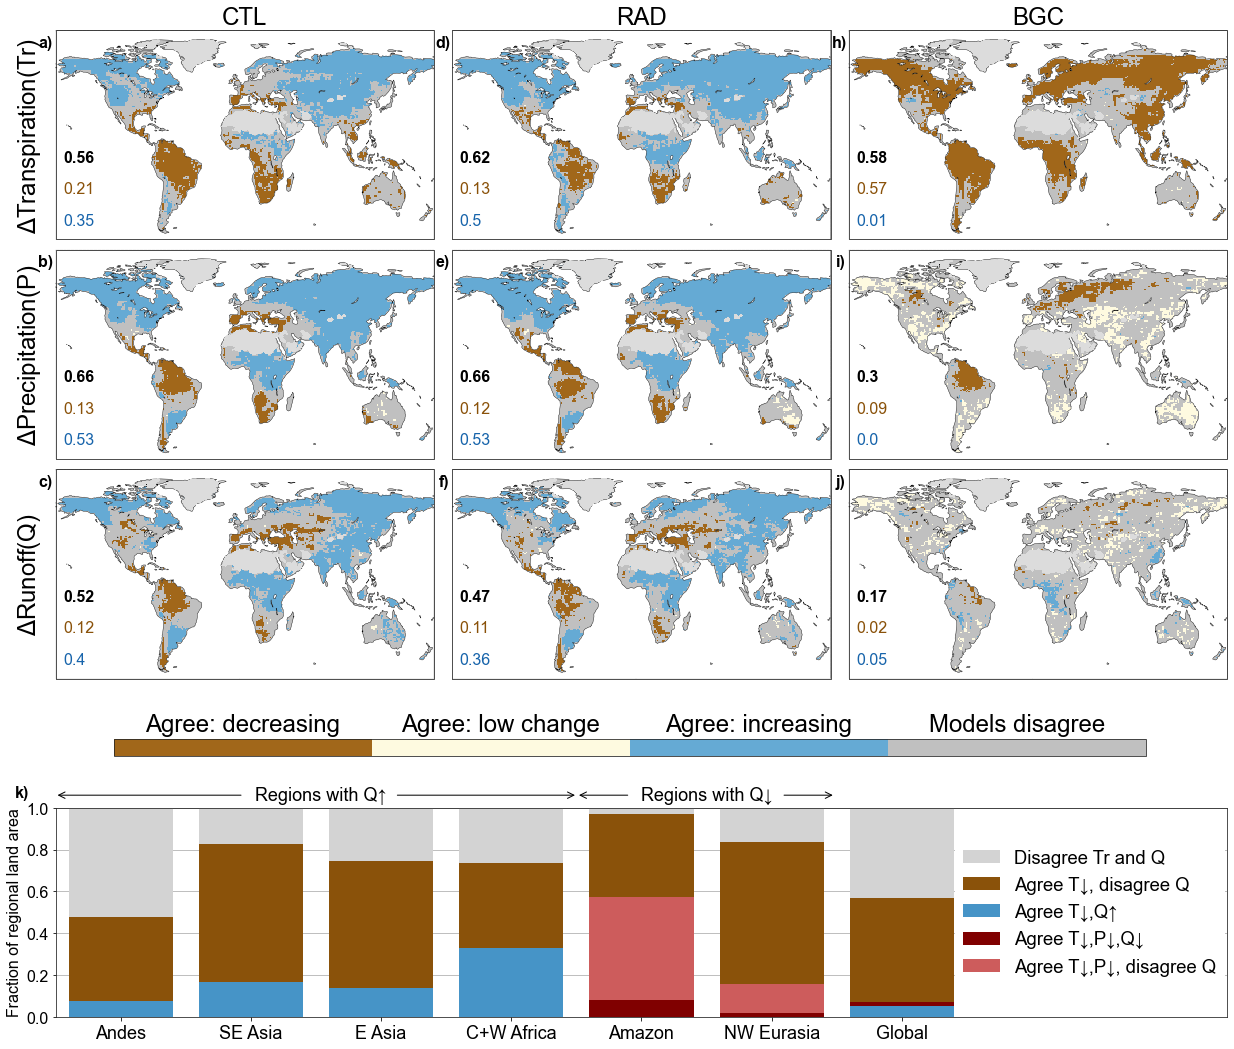

In [345]:
# inputs:
var = [deltaT_p_agr, deltaP_p_agr, deltaQ_p_agr]
vartitle = [r'$\Delta Transpiration (Tr)$',r'$\Delta Precipitation (P)$',r'$\Delta Runoff (Q)$']
varname = ['deltaT','deltaP','deltaQ']

# number of vars
nrows = 5
ncols = 3
exp = ['1pctCO2', '1pctCO2-rad', '1pctCO2-bgc']#,'fullplant']
exptitle = ['CTL','RAD','BGC']#,'Full Plant']

let = ['a)','b)','c)','d)','e)','f)','h)','i)','j)']
## FIGURE SETUP

# font stuff
#sns.set(font_scale=1.7, style="dark")
fsize=24
# make a figure
fig = plt.figure(figsize=(ncols*7,nrows*4)) # EDIT HERE
# set up grid for subplots & spacing
gs = gridspec.GridSpec(nrows=nrows, ncols=2*ncols, figure=fig) # I edited here. just say 4row 4col
gs.update(wspace=0.1, hspace=0.05)
# plot edge colors
plt.rcParams["axes.edgecolor"] = "0.15"
# list to hold our subplot axes
axes = []

# plot counter var
pltcntr = 0

# # loop thru cols, rows - b/c of the order I loaded in the data. 
for col in range(ncols):
    print(pltcntr)
    for row in range(nrows-2):
        
        # add an axis:
        ax = fig.add_subplot(gs[row,2*col:2*col+2], projection=ccrs.PlateCarree())
        
        # select ensemble mean data for desired var
        # data = input_dslist[col][0].sel(experiment=exp[row])
        # datavar = full_var_list[col]

        # select appropriate cmap and norm depending on which var.
        cmap = cmap_ag
        norm = norm_ag
        bounds = [0,4]
           
        # open ∆ctr data for this var
        var_toplot = var[row]
       
        # select significance mask, pass to cyclic point fn so it plots nicely... (cyc point fn accepts a dataset as an arg...)
        # if col == 0:
        #     sig_toplot = add_cyclic_to_da(((data.KS_Pval<0.05)).to_dataset(name='sig')) 
        #     ax.contourf(sig_toplot.lon, sig_toplot.lat, (~sig_toplot.sig), levels=[0.5, 1], colors='white', transform=ccrs.PlateCarree())

        # plot the data onto the ax
        var_toplot.sel(experiment=exp[col]).agreement.plot(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
        
        # add BARREN MASK FROM LAI
        # add ensemble mean lai mask
        ax.contourf(lai_barren_mask.lon, lai_barren_mask.lat, lai_barren_mask.data, levels=[0.5, 1], colors='gainsboro', transform=ccrs.PlateCarree(), zorder=3)
        
    
        # ADDITIONAL AXIS EDITS:

        # 'turn off' default plot title
        ax.set(title='')

        # add column (in this case, experiment) name above if we're on the first ROW 
        if row==0:
            ax.set_title(exptitle[col],fontsize=fsize)

        # add var name name on the left if we're in the first COLUMN
        if col==0:
            ax.text(x=-0.07, y=0.50, s=vartitle[row], va='center', ha='center',
                rotation='vertical', rotation_mode='anchor',
                transform=ax.transAxes,fontsize=fsize)

        
        #agree area label:
        frac_agree_area = agreeAreaFrac(var_toplot.sel(experiment=exp[col]))
        ax.text(0.02,0.37,frac_agree_area[2],transform=ax.transAxes,weight='bold')
        ax.text(0.02,0.22,frac_agree_area[0],transform=ax.transAxes,color=cmap_h(2))
        ax.text(0.02,0.07,frac_agree_area[1],transform=ax.transAxes,color=cmap_h(19))
        

        if let[pltcntr] in ['i)','f)','j)']:
            x = -0.035
        else:
            x = -0.045
        ax.text(x,.92,let[pltcntr],transform=ax.transAxes,weight='bold')
        
        
                
        # spacing:
        plt.subplots_adjust(hspace=0.05)
        # Trim antarctica out of our axis extents
        ax.set_extent((-170,180,-60,90), crs=ccrs.PlateCarree())
        # ocean & coastline
        ax.add_feature(cartopy.feature.OCEAN,zorder=2,edgecolor='black',facecolor='white',linewidth=0.4) # ocean clr?
        # big lakes
        ax.add_feature(big_lakes, linewidth=0.4, zorder=3,linestyle='-', edgecolor='black', facecolor='white')
        # greenland
        ax.add_geometries([greenland_poly], crs=ccrs.PlateCarree(), facecolor='gainsboro')
        ax.set_aspect("auto") 
        axes.append(ax)
        
        # update plot counter
        pltcntr += 1
        
        # add agreement colorbar
        #if pltcntr == 3:


#colorbar
ax = fig.add_subplot(gs[nrows-2,0:2*ncols-1],anchor=(1,1))
ax.set_visible(False)

cbar_ag = plt.colorbar(mpl.cm.ScalarMappable(norm=norm_ag, cmap=cmap_ag),ax=ax,
     ticks=np.arange(0.5, cmap_ag.N+1,1),
     orientation='horizontal',
     location='bottom',
     shrink=1.06,
     aspect=60,
     anchor=(-1,10))
  # (0.5,15)(left, down)

#cbar_ag.ax.set_yticks([0.5,1.5,2.5,3.5])
cbar_ag.ax.set_xticklabels(['Agree: decreasing', 'Agree: low change','Agree: increasing','Models disagree',''],fontsize=fsize)
cbar_ag.ax.tick_params(axis='both', labeltop=True,labelbottom=False,length=0)

### global/regl summary

ax = fig.add_subplot(gs[nrows-1,:2*ncols],anchor=(0,1))
#runoff increasing areas
regns = [9,24,22,15]
regnameswet = ['Andes','SE Asia','E Asia','C+W Africa'] 

for i,r in enumerate(regns):

    reg = srex == r
    agrQT = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 2) & (deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)
    agrQnT = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 2) & ~(deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)
    agrT = (deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)

    fracQT = getArea(agrQT)/getArea(reg)
    fracT = getArea(agrT)/getArea(reg)
    fracQnT = getArea(agrQnT)/getArea(reg)
    
    ax.bar(i,1,color='lightgrey')
    ax.bar(i,fracT,color=cmap_h(2))
    ax.bar(i,fracQT,color=cmap_h(17))
    

# runoff decreasing areas
offset = len(regnameswet)
regns = [7,18]# [12,13,18]
regnamesdry = ['Amazon','NW Eurasia'] 

for i,r in enumerate(regns):

    reg = srex == r
    agrQT = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0) & (deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)
    agrP = (deltaP_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)
    agrT = (deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)
    agrTP = (deltaP_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0) & agrT
    agrTPQ = agrQT & agrTP

    fracQT = getArea(agrQT)/getArea(reg)
    fracT = getArea(agrT)/getArea(reg)
    fracTP = getArea(agrTP)/getArea(reg)
    fracTPQ = getArea(agrTPQ)/getArea(reg)
    
    ax.bar(i+offset,1,color='lightgrey')
    ax.bar(i+offset,fracT,color=cmap_h(2))
    b5=ax.bar(i+offset,fracTP,color='indianred')
    b4=ax.bar(i+offset,fracTPQ,color='maroon')
    
#ax.text(offset-0.37,0.3,'Agree T↓,P↓\n Disagree Q',fontsize=15)

### global    
agrQT = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').agreement == 2) #& (deltaT_p_agr.sel(experiment='1pctCO2-bgc').agreement == 0)
agrQ = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').agreement == 0)
agrT = (deltaT_p_agr.sel(experiment='1pctCO2-bgc').agreement == 0)
fracQT = getArea(agrQT)/getArea(landmask.where(1-lai_barren_mask))
fracT = getArea(agrT)/getArea(landmask.where(1-lai_barren_mask))
fracQ = getArea(agrQ)/getArea(landmask.where(1-lai_barren_mask))

b1=ax.bar(i+offset+1,1,color='lightgrey')
b2=ax.bar(i+offset+1,fracT,color=cmap_h(2))
b3=ax.bar(i+offset+1,fracQT,color=cmap_h(17))
ax.bar(i+offset+1,fracQ,bottom=fracQT,color='maroon')
#ax.bar(i+1,fracQT,bottom=fracQnT,color='darkturquoise')   

xtlabs = regnameswet+regnamesdry+['Global']
ax.set_ylim(0,1)
ax.set_xticks(np.arange(0,len(xtlabs),1))
ax.set_xticklabels(xtlabs,fontsize=18)
ax.set_ylabel('Fraction of regional land area')

ax.legend([b1,b2,b3,b4,b5],['Disagree Tr and Q','Agree T↓, disagree Q','Agree T↓,Q↑','Agree T↓,P↓,Q↓','Agree T↓,P↓, disagree Q'],loc='center right',edgecolor=[1,1,1],framealpha=1,fontsize=18.5,bbox_to_anchor=(1.005,0.5))
ax.text(x,1.05,'k)',transform=ax.transAxes,weight='bold')
ax.grid(True)
ax.set_axisbelow(True)
## overlines
lny = 1.06
lab1 = 0.17
lab2 = 0.5
ax.set_xlim(-0.5,len(xtlabs)+1.5)

ax.annotate('', xy=(0, lny), xycoords='axes fraction', xytext=(lab1-0.01, lny),arrowprops=dict(arrowstyle="->", color='k'))
ax.text(lab1,lny-0.025,'Regions with Q↑',transform=ax.transAxes,fontsize=18)
ax.annotate('', xy=(lab1+0.12, lny), xycoords='axes fraction', xytext=(0.445, lny),arrowprops=dict(arrowstyle="<-", color='k'))

ax.annotate('', xy=(0.445, lny), xycoords='axes fraction', xytext=(lab2-0.01, lny),arrowprops=dict(arrowstyle="->", color='k'))
ax.text(lab2,lny-0.025,'Regions with Q↓',transform=ax.transAxes,fontsize=18)
ax.annotate('', xy=(lab2+0.12, lny), xycoords='axes fraction', xytext=(0.665, lny),arrowprops=dict(arrowstyle="<-", color='k'))



box = ax.get_position()
box.y0 = box.y0 + 0.07
box.y1 = box.y1 + 0.07
ax.set_position(box)

plt.tight_layout(h_pad=20,w_pad=5)

#plt.savefig(figure_dir + 'Fig1.pdf',bbox_inches='tight')
#plt.savefig(figure_dir + 'Fig1.png',bbox_inches='tight')


0
3
6


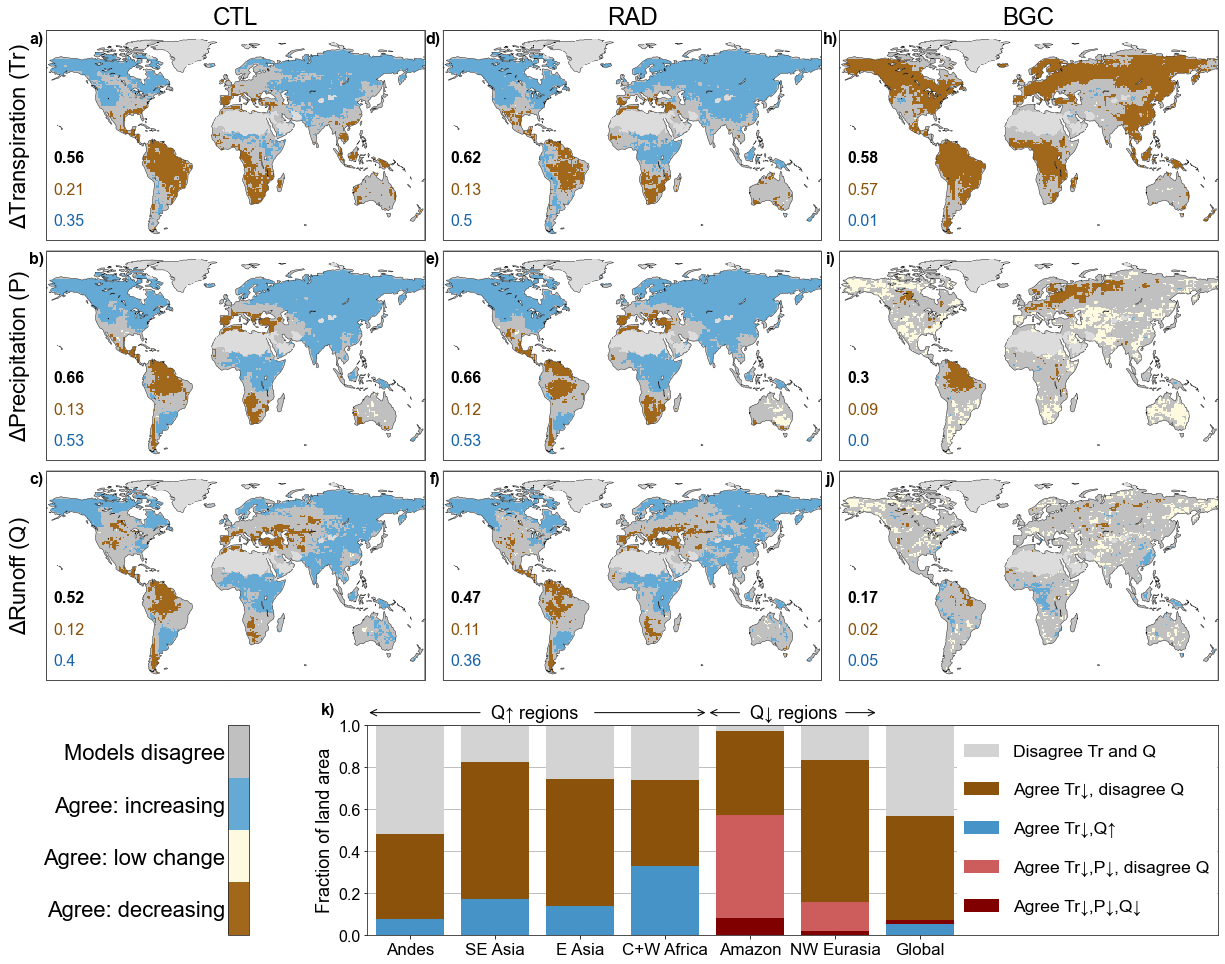

In [350]:
# inputs:
var = [deltaT_p_agr, deltaP_p_agr, deltaQ_p_agr]
vartitle = [r'$\Delta$Transpiration (Tr)',r'$\Delta$Precipitation (P)',r'$\Delta$Runoff (Q)']
varname = ['deltaT','deltaP','deltaQ']

# number of vars
nrows = 4
ncols = 3
exp = ['1pctCO2', '1pctCO2-rad', '1pctCO2-bgc']#,'fullplant']
exptitle = ['CTL','RAD','BGC']#,'Full Plant']

let = ['a)','b)','c)','d)','e)','f)','h)','i)','j)']
## FIGURE SETUP

# font stuff
#sns.set(font_scale=1.7, style="dark")
fsize=24
# make a figure
fig = plt.figure(figsize=(ncols*7,nrows*4)) # EDIT HERE
# set up grid for subplots & spacing
gs = gridspec.GridSpec(nrows=nrows, ncols=2*ncols, figure=fig) # I edited here. just say 4row 4col
gs.update(wspace=0.1, hspace=0.05)
# plot edge colors
plt.rcParams["axes.edgecolor"] = "0.15"
# list to hold our subplot axes
axes = []

# plot counter var
pltcntr = 0

# # loop thru cols, rows - b/c of the order I loaded in the data. 
for col in range(ncols):
    print(pltcntr)
    for row in range(nrows-1):
        
        # add an axis:
        ax = fig.add_subplot(gs[row,2*col:2*col+2], projection=ccrs.PlateCarree())
        
        # select ensemble mean data for desired var
        # data = input_dslist[col][0].sel(experiment=exp[row])
        # datavar = full_var_list[col]

        # select appropriate cmap and norm depending on which var.
        cmap = cmap_ag
        norm = norm_ag
        bounds = [0,4]
           
        # open ∆ctr data for this var
        var_toplot = var[row]
       
        # select significance mask, pass to cyclic point fn so it plots nicely... (cyc point fn accepts a dataset as an arg...)
        # if col == 0:
        #     sig_toplot = add_cyclic_to_da(((data.KS_Pval<0.05)).to_dataset(name='sig')) 
        #     ax.contourf(sig_toplot.lon, sig_toplot.lat, (~sig_toplot.sig), levels=[0.5, 1], colors='white', transform=ccrs.PlateCarree())

        # plot the data onto the ax
        var_toplot.sel(experiment=exp[col]).agreement.plot(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
        
        # add BARREN MASK FROM LAI
        # add ensemble mean lai mask
        ax.contourf(lai_barren_mask.lon, lai_barren_mask.lat, lai_barren_mask.data, levels=[0.5, 1], colors='gainsboro', transform=ccrs.PlateCarree(), zorder=3)
        
    
        # ADDITIONAL AXIS EDITS:

        # 'turn off' default plot title
        ax.set(title='')

        # add column (in this case, experiment) name above if we're on the first ROW 
        if row==0:
            ax.set_title(exptitle[col],fontsize=fsize)

        # add var name name on the left if we're in the first COLUMN
        if col==0:
            ax.text(x=-0.07, y=0.50, s=vartitle[row], va='center', ha='center',
                rotation='vertical', rotation_mode='anchor',
                transform=ax.transAxes,fontsize=fsize-2)

        
        #agree area label:
        frac_agree_area = agreeAreaFrac(var_toplot.sel(experiment=exp[col]))
        ax.text(0.02,0.37,frac_agree_area[2],transform=ax.transAxes,weight='bold')
        ax.text(0.02,0.22,frac_agree_area[0],transform=ax.transAxes,color=cmap_h(2))
        ax.text(0.02,0.07,frac_agree_area[1],transform=ax.transAxes,color=cmap_h(19))
        

        if let[pltcntr] in ['i)','f)','j)']:
            x = -0.035
        else:
            x = -0.045
        ax.text(x,.94,let[pltcntr],transform=ax.transAxes,weight='bold')
        
        
                
        # spacing:
        plt.subplots_adjust(hspace=0.05)
        # Trim antarctica out of our axis extents
        ax.set_extent((-170,180,-60,90), crs=ccrs.PlateCarree())
        # ocean & coastline
        ax.add_feature(cartopy.feature.OCEAN,zorder=2,edgecolor='black',facecolor='white',linewidth=0.4) # ocean clr?
        # big lakes
        ax.add_feature(big_lakes, linewidth=0.4, zorder=3,linestyle='-', edgecolor='black', facecolor='white')
        # greenland
        ax.add_geometries([greenland_poly], crs=ccrs.PlateCarree(), facecolor='gainsboro')
        ax.set_aspect("auto") 
        axes.append(ax)
        
        # update plot counter
        pltcntr += 1
        
        # add agreement colorbar
        #if pltcntr == 3:


#colorbar
ax = fig.add_subplot(gs[nrows-1,0:2])#,anchor=(1,1))
ax.set_visible(False)

cbar_ag = plt.colorbar(mpl.cm.ScalarMappable(norm=norm_ag, cmap=cmap_ag),ax=ax,
     ticks=np.arange(0.5, cmap_ag.N+1,1),
     #orientation='vertical',
     anchor=(-2, 0),
     panchor=(0.0, 0), 
     pad=1.05,   #shrink=1.06,
     aspect=10)
     #anchor=(-1,10))
  # (0.5,15)(left, down)

#cbar_ag.ax.set_yticks([0.5,1.5,2.5,3.5])
cbar_ag.ax.set_yticklabels(['Agree: decreasing', 'Agree: low change','Agree: increasing','Models disagree',''],fontsize=fsize-2)
cbar_ag.ax.tick_params(axis='both', labelleft=True,labelright=False,length=0)

box = cbar_ag.ax.get_position()
box.y0 = box.y0 - 0.03
box.y1 = box.y1 - 0.03
box.x0 = box.x0 - 0.015
cbar_ag.ax.set_position(box)


### global/regl summary

ax = fig.add_subplot(gs[nrows-1,2:2*ncols])#,anchor=(0,1))
#runoff increasing areas
regns = [9,24,22,15]
regnameswet = ['Andes','SE Asia','E Asia','C+W Africa'] 

for i,r in enumerate(regns):

    reg = srex == r
    agrQT = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 2) & (deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)
    agrQnT = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 2) & ~(deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)
    agrT = (deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)

    fracQT = getArea(agrQT)/getArea(reg)
    fracT = getArea(agrT)/getArea(reg)
    fracQnT = getArea(agrQnT)/getArea(reg)
    
    ax.bar(i,1,color='lightgrey')
    ax.bar(i,fracT,color=cmap_h(2))
    ax.bar(i,fracQT,color=cmap_h(17))
    

# runoff decreasing areas
offset = len(regnameswet)
regns = [7,18]# [12,13,18]
regnamesdry = ['Amazon','NW Eurasia'] 

for i,r in enumerate(regns):

    reg = srex == r
    agrQT = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0) & (deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)
    agrP = (deltaP_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)
    agrT = (deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)
    agrTP = (deltaP_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0) & agrT
    agrTPQ = agrQT & agrTP

    fracQT = getArea(agrQT)/getArea(reg)
    fracT = getArea(agrT)/getArea(reg)
    fracTP = getArea(agrTP)/getArea(reg)
    fracTPQ = getArea(agrTPQ)/getArea(reg)
    
    ax.bar(i+offset,1,color='lightgrey')
    ax.bar(i+offset,fracT,color=cmap_h(2))
    b5=ax.bar(i+offset,fracTP,color='indianred')
    b4=ax.bar(i+offset,fracTPQ,color='maroon')
    
#ax.text(offset-0.37,0.3,'Agree T↓,P↓\n Disagree Q',fontsize=15)

### global    
agrQT = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').agreement == 2) #& (deltaT_p_agr.sel(experiment='1pctCO2-bgc').agreement == 0)
agrQ = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').agreement == 0)
agrT = (deltaT_p_agr.sel(experiment='1pctCO2-bgc').agreement == 0)
fracQT = getArea(agrQT)/getArea(landmask.where(1-lai_barren_mask))
fracT = getArea(agrT)/getArea(landmask.where(1-lai_barren_mask))
fracQ = getArea(agrQ)/getArea(landmask.where(1-lai_barren_mask))

b1=ax.bar(i+offset+1,1,color='lightgrey')
b2=ax.bar(i+offset+1,fracT,color=cmap_h(2))
b3=ax.bar(i+offset+1,fracQT,color=cmap_h(17))
ax.bar(i+offset+1,fracQ,bottom=fracQT,color='maroon')
#ax.bar(i+1,fracQT,bottom=fracQnT,color='darkturquoise')   

xtlabs = regnameswet+regnamesdry+['Global']
ax.set_ylim(0,1)
ax.set_xticks(np.arange(0,len(xtlabs),1))
ax.set_xticklabels(xtlabs,fontsize=17)
ax.set_ylabel('Fraction of land area',fontsize=18)

ax.legend([b1,b2,b3,b5,b4],['Disagree Tr and Q','Agree Tr↓, disagree Q','Agree Tr↓,Q↑','Agree Tr↓,P↓, disagree Q','Agree Tr↓,P↓,Q↓'],loc='center right',edgecolor=[1,1,1],framealpha=1,fontsize=17.5,bbox_to_anchor=(1.008,0.5),labelspacing=1.3)
ax.text(x-0.02,1.05,'k)',transform=ax.transAxes,weight='bold')
ax.grid(True)
ax.set_axisbelow(True)

## overlines
lny = 1.06
lab1 = 0.145
lab2 = 0.45
ax.set_xlim(-0.5,len(xtlabs)+2.5)

ax.annotate('', xy=(0, lny), xycoords='axes fraction', xytext=(lab1-0.01, lny),arrowprops=dict(arrowstyle="->", color='k'))
ax.text(lab1,lny-0.025,'Q↑ regions',transform=ax.transAxes,fontsize=18)
ax.annotate('', xy=(lab1+0.12, lny), xycoords='axes fraction', xytext=(0.4, lny),arrowprops=dict(arrowstyle="<-", color='k'))

ax.annotate('', xy=(0.4, lny), xycoords='axes fraction', xytext=(lab2-0.01, lny),arrowprops=dict(arrowstyle="->", color='k'))
ax.text(lab2,lny-0.025,'Q↓ regions',transform=ax.transAxes,fontsize=18)
ax.annotate('', xy=(lab2+0.11, lny), xycoords='axes fraction', xytext=(0.6, lny),arrowprops=dict(arrowstyle="<-", color='k'))



box = ax.get_position()
box.y0 = box.y0 - 0.03
box.y1 = box.y1 - 0.03
box.x0 = box.x0 - 0.05
ax.set_position(box)

plt.tight_layout(h_pad=20,w_pad=5)

plt.savefig(figure_dir + 'Fig1.pdf',bbox_inches='tight')
plt.savefig(figure_dir + 'Fig1.png',bbox_inches='tight')

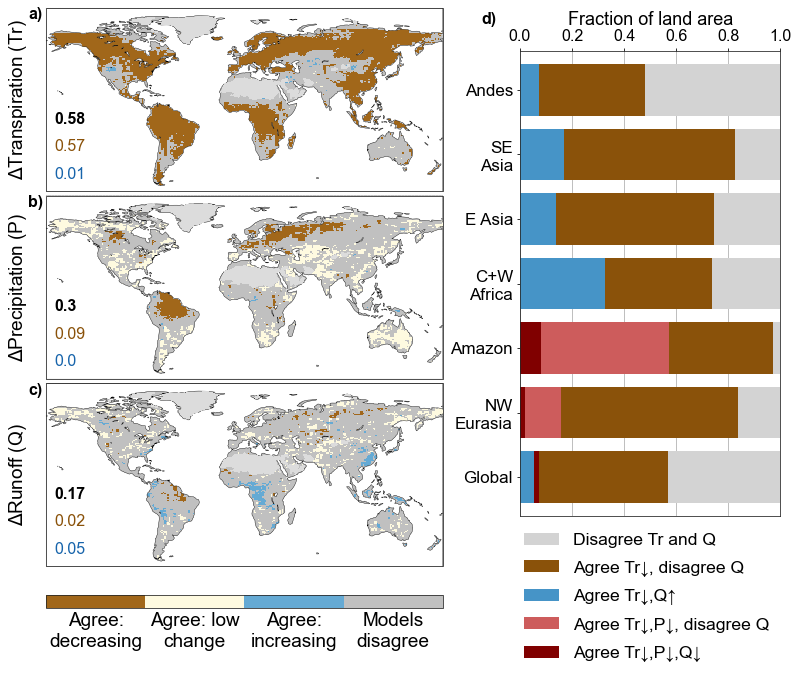

In [28]:
### just bgc

# inputs:
var = [deltaT_p_agr, deltaP_p_agr, deltaQ_p_agr]
vartitle = [r'$\Delta$Transpiration (Tr)',r'$\Delta$Precipitation (P)',r'$\Delta$Runoff (Q)']
varname = ['deltaT','deltaP','deltaQ']

# number of vars
nrows = 4
ncols = 3
experiment = '1pctCO2-bgc'
exptitle = ['BGC']#,'Full Plant']

let = ['a)','b)','c)','d)','e)','f)','h)','i)','j)']
## FIGURE SETUP

# font stuff
#sns.set(font_scale=1.7, style="dark")
fsize=24
# make a figure
fig = plt.figure(figsize=(12,12)) # EDIT HERE
# set up grid for subplots & spacing
gs = gridspec.GridSpec(7,5, figure=fig)
gs.update(wspace=0.1, hspace=0.05)
# plot edge colors
plt.rcParams["axes.edgecolor"] = "0.15"
# list to hold our subplot axes
axes = []

# # loop thru cols, rows - b/c of the order I loaded in the data. 

for i,var_toplot in enumerate(var):

    # add an axis:
    ax = fig.add_subplot(gs[2*i:2*i+2,:3], projection=ccrs.PlateCarree())

    # select ensemble mean data for desired var
    # data = input_dslist[col][0].sel(experiment=exp[row])
    # datavar = full_var_list[col]

    # select appropriate cmap and norm depending on which var.
    cmap = cmap_ag
    norm = norm_ag
    bounds = [0,4]

    # open ∆ctr data for this var
    #var_toplot = var[row]

    # plot the data onto the ax
    var_toplot.sel(experiment=experiment).agreement.plot(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)

    # add BARREN MASK FROM LAI
    # add ensemble mean lai mask
    ax.contourf(lai_barren_mask.lon, lai_barren_mask.lat, lai_barren_mask.data, levels=[0.5, 1], colors='gainsboro', transform=ccrs.PlateCarree(), zorder=3)


    # ADDITIONAL AXIS EDITS:

    # 'turn off' default plot title
    ax.set(title='')

    # add column (in this case, experiment) name above if we're on the first ROW 
    # if row==0:
    #     ax.set_title(exptitle[col],fontsize=fsize)

    # add var name name on the left if we're in the first COLUMN
    ax.text(x=-0.07, y=0.50, s=vartitle[i], va='center', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes,fontsize=fsize-5)


    #agree area label:
    frac_agree_area = agreeAreaFrac(var_toplot.sel(experiment=experiment))
    ax.text(0.02,0.37,frac_agree_area[2],transform=ax.transAxes,weight='bold')
    ax.text(0.02,0.22,frac_agree_area[0],transform=ax.transAxes,color=cmap_h(2))
    ax.text(0.02,0.07,frac_agree_area[1],transform=ax.transAxes,color=cmap_h(19))


    if let[i] in ['i)','f)','j)']:
        x = -0.035
    else:
        x = -0.045
    ax.text(x,.94,let[i],transform=ax.transAxes,weight='bold')


    # Trim antarctica out of our axis extents
    ax.set_extent((-170,180,-60,90), crs=ccrs.PlateCarree())
    # ocean & coastline
    ax.add_feature(cartopy.feature.OCEAN,zorder=2,edgecolor='black',facecolor='white',linewidth=0.4) # ocean clr?
    # big lakes
    ax.add_feature(big_lakes, linewidth=0.4, zorder=3,linestyle='-', edgecolor='black', facecolor='white')
    # greenland
    ax.add_geometries([greenland_poly], crs=ccrs.PlateCarree(), facecolor='gainsboro')
    ax.set_aspect("auto") 
    axes.append(ax)




#colorbar
ax = fig.add_subplot(gs[6,:3])#,anchor=(1,1))
ax.set_visible(False)

cbar_ag = plt.colorbar(mpl.cm.ScalarMappable(norm=norm_ag, cmap=cmap_ag),ax=ax,
     ticks=np.arange(0.5, cmap_ag.N+1,1),
     orientation='horizontal',
     #anchor=(-2, 0),
     #panchor=(0.0, 0), 
     pad=1.05,   #shrink=1.06,
     aspect=30)
     #anchor=(-1,10))
  # (0.5,15)(left, down)

#cbar_ag.ax.set_yticks([0.5,1.5,2.5,3.5])
cbar_ag.ax.set_xticklabels(['Agree:\ndecreasing', 'Agree: low\nchange','Agree:\nincreasing','Models\ndisagree',''],fontsize=fsize-5)
cbar_ag.ax.tick_params(axis='both', labelleft=True,labelright=False,length=0)

box = cbar_ag.ax.get_position()
box.y0 = box.y0 + 0.06
box.y1 = box.y1 + 0.06
#box.x0 = box.x0 - 0.015
cbar_ag.ax.set_position(box)


### global/regl summary

ax = fig.add_subplot(gs[:5,3:])#,anchor=(0,1))
#runoff increasing areas
regns = [9,24,22,15]
regnameswet = ['Andes','SE\nAsia','E Asia','C+W\nAfrica'] 

for i,r in enumerate(regns):

    reg = srex == r
    agrQT = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 2) & (deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)
    agrQnT = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 2) & ~(deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)
    agrT = (deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)

    fracQT = getArea(agrQT)/getArea(reg)
    fracT = getArea(agrT)/getArea(reg)
    fracQnT = getArea(agrQnT)/getArea(reg)
    
    ax.barh(i,1,color='lightgrey')
    ax.barh(i,fracT,color=cmap_h(2))
    ax.barh(i,fracQT,color=cmap_h(17))
    

# runoff decreasing areas
offset = len(regnameswet)
regns = [7,18]# [12,13,18]
regnamesdry = ['Amazon','NW\nEurasia'] 

for i,r in enumerate(regns):

    reg = srex == r
    agrQT = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0) & (deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)
    agrP = (deltaP_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)
    agrT = (deltaT_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0)
    agrTP = (deltaP_p_agr.sel(experiment='1pctCO2-bgc').where(srex==r).agreement == 0) & agrT
    agrTPQ = agrQT & agrTP

    fracQT = getArea(agrQT)/getArea(reg)
    fracT = getArea(agrT)/getArea(reg)
    fracTP = getArea(agrTP)/getArea(reg)
    fracTPQ = getArea(agrTPQ)/getArea(reg)
    
    ax.barh(i+offset,1,color='lightgrey')
    ax.barh(i+offset,fracT,color=cmap_h(2))
    b5=ax.barh(i+offset,fracTP,color='indianred')
    b4=ax.barh(i+offset,fracTPQ,color='maroon')
    
#ax.text(offset-0.37,0.3,'Agree T↓,P↓\n Disagree Q',fontsize=15)

### global    
agrQT = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').agreement == 2) #& (deltaT_p_agr.sel(experiment='1pctCO2-bgc').agreement == 0)
agrQ = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc').agreement == 0)
agrT = (deltaT_p_agr.sel(experiment='1pctCO2-bgc').agreement == 0)
fracQT = getArea(agrQT)/getArea(landmask.where(1-lai_barren_mask))
fracT = getArea(agrT)/getArea(landmask.where(1-lai_barren_mask))
fracQ = getArea(agrQ)/getArea(landmask.where(1-lai_barren_mask))

b1=ax.barh(i+offset+1,1,color='lightgrey')
b2=ax.barh(i+offset+1,fracT,color=cmap_h(2))
b3=ax.barh(i+offset+1,fracQT,color=cmap_h(17))
ax.barh(i+offset+1,fracQ,left=fracQT,color='maroon')
#ax.bar(i+1,fracQT,bottom=fracQnT,color='darkturquoise')   

xtlabs = regnameswet+regnamesdry+['Global']
ax.set_xlim(0,1)
ax.set_yticks(np.arange(0,len(xtlabs),1))
ax.set_yticklabels(xtlabs,fontsize=17)
ax.set_xlabel('Fraction of land area',fontsize=18)

ax.legend([b1,b2,b3,b5,b4],['Disagree Tr and Q','Agree Tr↓, disagree Q','Agree Tr↓,Q↑','Agree Tr↓,P↓, disagree Q','Agree Tr↓,P↓,Q↓'],loc='center right',
          edgecolor=[1,1,1],framealpha=1,fontsize=17.5,
          bbox_to_anchor=(1.02,-0.175),labelspacing=.7)

ax.text(-0.15,1.06,'d)',transform=ax.transAxes,weight='bold')
ax.grid(True)
ax.set_axisbelow(True)
ax.set_ylim(-.6,6.6)
ax.set_ylim(ax.get_ylim()[::-1])
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
## overlines
# lny = 1.06
# lab1 = 0.145
# lab2 = 0.45
# ax.set_xlim(-0.5,len(xtlabs)+2.5)

# ax.annotate('', xy=(0, lny), xycoords='axes fraction', xytext=(lab1-0.01, lny),arrowprops=dict(arrowstyle="->", color='k'))
# ax.text(lab1,lny-0.025,'Q↑ regions',transform=ax.transAxes,fontsize=18)
# ax.annotate('', xy=(lab1+0.12, lny), xycoords='axes fraction', xytext=(0.4, lny),arrowprops=dict(arrowstyle="<-", color='k'))

# ax.annotate('', xy=(0.4, lny), xycoords='axes fraction', xytext=(lab2-0.01, lny),arrowprops=dict(arrowstyle="->", color='k'))
# ax.text(lab2,lny-0.025,'Q↓ regions',transform=ax.transAxes,fontsize=18)
# ax.annotate('', xy=(lab2+0.11, lny), xycoords='axes fraction', xytext=(0.6, lny),arrowprops=dict(arrowstyle="<-", color='k'))



box = ax.get_position()
box.x0 = box.x0 + 0.075
box.x1 = box.x1 + 0.075
box.y0 = box.y0 - 0.05
box.y1 = box.y1 -0.05
#box.x0 = box.x0 - 0.05
ax.set_position(box)

plt.tight_layout()

plt.savefig(figure_dir + 'Fig1-bgc.pdf',bbox_inches='tight')
plt.savefig(figure_dir + 'Fig1-bgc.png',bbox_inches='tight')

0
3


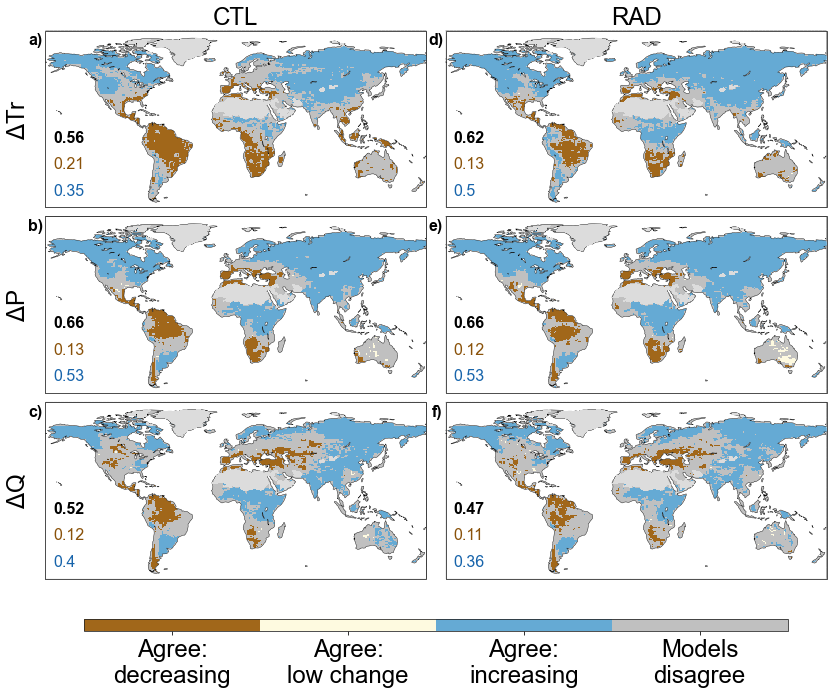

In [50]:
# inputs:
var = [deltaT_p_agr, deltaP_p_agr, deltaQ_p_agr]
vartitle = [r'$\Delta Tr$',r'$\Delta P$',r'$\Delta Q$']
varname = ['deltaT','deltaP','deltaQ']


# plot title
plttitle = ''#'Ensemble spread and agreement'

# number of vars
nrows = 3
ncols = 2
exp = ['1pctCO2', '1pctCO2-rad']#,'fullplant']
exptitle = ['CTL','RAD']#,'Full Plant']

let = ['a)','b)','c)','d)','e)','f)','h)','i)','j)']
## FIGURE SETUP

# font stuff
#sns.set(font_scale=1.7, style="dark")
fsize=24
# make a figure
fig = plt.figure(figsize=(ncols*7,nrows*4.5)) # EDIT HERE
# set up grid for subplots & spacing
gs = gridspec.GridSpec(nrows=nrows+1, ncols=ncols, figure=fig) # I edited here. just say 4row 4col
gs.update(wspace=0.05, hspace=0.05)
# plot edge colors
plt.rcParams["axes.edgecolor"] = "0.15"
# list to hold our subplot axes
axes = []

# plot counter var
pltcntr = 0

# # loop thru cols, rows - b/c of the order I loaded in the data. 
for col in range(ncols):
    print(pltcntr)
    for row in range(nrows):
        
        # add an axis:
        ax = fig.add_subplot(gs[row,col], projection=ccrs.PlateCarree())
        
        # select ensemble mean data for desired var
        # data = input_dslist[col][0].sel(experiment=exp[row])
        # datavar = full_var_list[col]

        # select appropriate cmap and norm depending on which var.
        cmap = cmap_ag
        norm = norm_ag
        bounds = [0,4]
           
        # open ∆ctr data for this var
        var_toplot = var[row]
       
        # select significance mask, pass to cyclic point fn so it plots nicely... (cyc point fn accepts a dataset as an arg...)
        # if col == 0:
        #     sig_toplot = add_cyclic_to_da(((data.KS_Pval<0.05)).to_dataset(name='sig')) 
        #     ax.contourf(sig_toplot.lon, sig_toplot.lat, (~sig_toplot.sig), levels=[0.5, 1], colors='white', transform=ccrs.PlateCarree())

        # plot the data onto the ax
        var_toplot.sel(experiment=exp[col]).agreement.plot(ax=ax, cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), add_colorbar=False)
        
        # add BARREN MASK FROM LAI
        # add ensemble mean lai mask
        ax.contourf(lai_barren_mask.lon, lai_barren_mask.lat, lai_barren_mask.data, levels=[0.5, 1], colors='gainsboro', transform=ccrs.PlateCarree(), zorder=3)
        
    
        # ADDITIONAL AXIS EDITS:

        # 'turn off' default plot title
        ax.set(title='')

        # add column (in this case, experiment) name above if we're on the first ROW 
        if row==0:
            ax.set_title(exptitle[col],fontsize=fsize)

        # add var name name on the left if we're in the first COLUMN
        if col==0:
            ax.text(x=-0.07, y=0.50, s=vartitle[row], va='center', ha='center',
                rotation='vertical', rotation_mode='anchor',
                transform=ax.transAxes,fontsize=fsize)

        
        #agree area label:
        frac_agree_area = agreeAreaFrac(var_toplot.sel(experiment=exp[col]))
        ax.text(0.02,0.37,frac_agree_area[2],transform=ax.transAxes,weight='bold')
        ax.text(0.02,0.22,frac_agree_area[0],transform=ax.transAxes,color=cmap_h(2))
        ax.text(0.02,0.07,frac_agree_area[1],transform=ax.transAxes,color=cmap_h(19))
        

        if let[pltcntr] in ['i)','f)','j)']:
            x = -0.035
        else:
            x = -0.045
        ax.text(x,.92,let[pltcntr],transform=ax.transAxes,weight='bold')
        
        
                
        # spacing:
        plt.subplots_adjust(hspace=0.05)
        # Trim antarctica out of our axis extents
        ax.set_extent((-170,180,-60,90), crs=ccrs.PlateCarree())
        # ocean & coastline
        ax.add_feature(cartopy.feature.OCEAN,zorder=2,edgecolor='black',facecolor='white',linewidth=0.4) # ocean clr?
        # big lakes
        ax.add_feature(big_lakes, linewidth=0.4, zorder=3,linestyle='-', edgecolor='black', facecolor='white')
        # greenland
        ax.add_geometries([greenland_poly], crs=ccrs.PlateCarree(), facecolor='gainsboro')
        ax.set_aspect("auto") 
        axes.append(ax)
        
        # update plot counter
        pltcntr += 1
        
        # add agreement colorbar
        #if pltcntr == 3:


# overall plot title:        
plt.suptitle(plttitle, y=0.95) # note: will have to change y if i change axis sizes...
 

ax = fig.add_subplot(gs[nrows,0:ncols],anchor=(0.5,0))
ax.set_visible(False)

cbar_ag = plt.colorbar(mpl.cm.ScalarMappable(norm=norm_ag, cmap=cmap_ag),ax=ax,
     ticks=np.arange(0.5, cmap_ag.N+1,1),
     orientation='horizontal',
     location='bottom',
     shrink=0.9,
     aspect=60,
     anchor=(0.5,9))
    # panchor=(0,0))  # (left, down)

#cbar_ag.ax.set_yticks([0.5,1.5,2.5,3.5])
cbar_ag.ax.set_xticklabels(['Agree:\ndecreasing', 'Agree:\nlow change','Agree:\nincreasing','Models\ndisagree',''],fontsize=fsize)
        
# add time and script name to bottom of plot...
# get datetime
#now = datetime.now()

# add text
#fig.text(0.11, 0.05, 'Created: %s' %now.strftime("%Y-%m-%d %H:%M:%S"), fontsize='small')
#fig.text(0.9, 0.05, scriptname, ha='right', fontsize='small')


# SAVE FIGURE
# if savefig == True:
#     print('saving figure.', flush=True)
#     # SAVING AS png
#     plt.savefig(os.path.join(figure_dir, 'soil-moisture-ensemble-agreement.pdf'), format='pdf', facecolor='white', transparent=False)
    # AND as pdf
    #plt.savefig(os.path.join(figure_dir, 'greening_drying_plt_KS_test_wateryear_6_1.pdf'), format='pdf')
    
# SHOW:
plt.tight_layout(h_pad=15,w_pad=3)

plt.savefig(figure_dir + 'FigS4_new.pdf',bbox_inches='tight')
plt.savefig(figure_dir + 'FigS4_new.png',bbox_inches='tight')

Fig. 1 other key reported numbers:

In [42]:
### fraction of agree Tr where agree Q: BGC

agrT_posneg = (deltaT_p_agr.sel(experiment='1pctCO2-bgc') == 0) | (deltaT_p_agr.sel(experiment='1pctCO2-bgc') == 2)
agrQ_posneg = (deltaQ_p_agr.sel(experiment='1pctCO2-bgc') == 0) | (deltaQ_p_agr.sel(experiment='1pctCO2-bgc') == 2)

overlaparea = (agrQ_posneg & agrT_posneg).agreement.weighted(np.cos(np.deg2rad(agrT_posneg.lat))).sum(dim=['lat','lon'])
tarea = agrT_posneg.agreement.weighted(np.cos(np.deg2rad(agrT_posneg.lat))).sum(dim=['lat','lon'])

total_area = landmask.where(1-lai_barren_mask).weighted(np.cos(np.deg2rad(landmask.lat))).sum(dim=['lat','lon'])

overlaparea/tarea

<xarray.DataArray 'agreement' ()>
array(0.10635877)
Coordinates:
    experiment  <U11 '1pctCO2-bgc'

In [383]:
model=current_ensemble[11]
dpreg=deltaP.sel(experiment=experiment,model=model).where(srex==7).deltaPr.weighted(np.cos(np.deg2rad(deltaT.lat))).mean(dim=['lat','lon'])
dtreg=deltaT.sel(experiment=experiment,model=model).where(srex==7).deltaT.weighted(np.cos(np.deg2rad(deltaT.lat))).mean(dim=['lat','lon'])
dqreg=deltaQ.sel(experiment=experiment,model=model).where(srex==7).deltaQ.weighted(np.cos(np.deg2rad(deltaT.lat))).mean(dim=['lat','lon'])
dpreg,dtreg,dqreg

(<xarray.DataArray 'deltaPr' ()>
 array(-365.34856965)
 Coordinates:
     model       <U11 'UKESM1-0-LL'
     experiment  <U7 '1pctCO2',
 <xarray.DataArray 'deltaT' ()>
 array(-216.57013604)
 Coordinates:
     model       <U11 'UKESM1-0-LL'
     experiment  <U7 '1pctCO2',
 <xarray.DataArray 'deltaQ' ()>
 array(-161.33923039)
 Coordinates:
     model       <U11 'UKESM1-0-LL'
     experiment  <U7 '1pctCO2')

### LAI change agreement

In [40]:
np.arange(0.5, cmap_ag.N,1)

array([0.5, 1.5, 2.5, 3.5])

Text(-0.05, 1.02, 'e)')

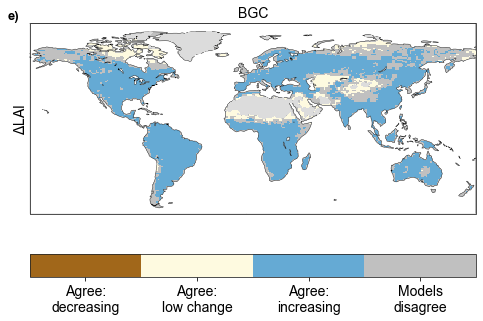

In [61]:
deltaLAI = xr.open_dataset(os.path.join(root_dir,load_dir, 'deltaLAI_abs.nc'))
tol = 0.1
thresh_agree = 2/3
deltaLAI_agr = ensemble_agreement(deltaLAI,tol=tol,thresh_agree=thresh_agree)

cmap = cmap_ag
norm = norm_ag
bounds = [0,4]
ticklabs = ['Agree:\ndecreasing', 'Agree:\nlow change','Agree:\nincreasing','Models\ndisagree']

fig = plt.figure(figsize=(8,5))
gs = gridspec.GridSpec(nrows=1, ncols=1, figure=fig) # I edited here. just say 4row 4col
gs.update(wspace=0.1, hspace=0.05)
plt.rcParams["axes.edgecolor"] = "0.15"
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
p = deltaLAI_agr.sel(experiment='1pctCO2-bgc').agreement.plot(ax=ax, cmap=cmap, norm=norm, 
                                                          transform=ccrs.PlateCarree(), 
                                                          add_colorbar=False)
cbar = plt.colorbar(p,ax=ax, orientation='horizontal')
cbar.set_ticks(ticks=np.arange(0.5, cmap_ag.N,1), labels=ticklabs,fontsize=14)
                                                      

# add ensemble mean lai mask
ax.contourf(lai_barren_mask.lon, lai_barren_mask.lat, lai_barren_mask.data, levels=[0.5, 1], colors='gainsboro', transform=ccrs.PlateCarree(), zorder=3)

# Trim antarctica out of our axis extents
ax.set_extent((-170,180,-60,90), crs=ccrs.PlateCarree())
# ocean & coastline
ax.add_feature(cartopy.feature.OCEAN,zorder=2,edgecolor='black',facecolor='white',linewidth=0.4) # ocean clr?
# big lakes
ax.add_feature(big_lakes, linewidth=0.4, zorder=3,linestyle='-', edgecolor='black', facecolor='white')
# greenland
ax.add_geometries([greenland_poly], crs=ccrs.PlateCarree(), facecolor='gainsboro')
ax.set_aspect("auto") 


ax.set_title('BGC',fontsize=14)
ax.text(x=-0.02, y=0.50, s=r'$\Delta$LAI', va='center', ha='center',
                rotation='vertical', rotation_mode='anchor',
                transform=ax.transAxes,fontsize=14)
ax.text(x=-0.05, y=1.02, s='e)',weight='bold',
                transform=ax.transAxes,fontsize=13)